In [1]:
import math
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from qiskit import QuantumCircuit, transpile, assemble
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService , SamplerV2
from qiskit.quantum_info import Operator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.visualization import array_to_latex
from qiskit_aer import StatevectorSimulator, AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime.fake_provider import FakeKyiv

In [2]:
#Number of Qubits
n = 2 

#Load b
b = np.array([0,1])  
b_norm = b / np.linalg.norm(b)
initialn= int(np.log2(len(b_norm)))
initialstate = QuantumCircuit(initialn)
initialstate.initialize(b_norm, range(initialn))

#Define A
A = np.array([[1, -1/3],
             [-1/3, 1]]) 

#Define U
t  = 3 * np.pi / 4
U_matrix = sp.linalg.expm(1j*A*t)
U = Operator(U_matrix)
U_gate = U.to_instruction()
print(U_gate)
array_to_latex(A)

Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.5+0.5j,  0.5+0.5j],
       [ 0.5+0.5j, -0.5+0.5j]])])


<IPython.core.display.Latex object>

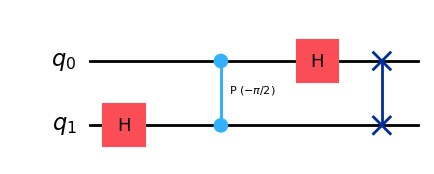

In [3]:
#Quantum Fourier Transform
q = initialn+n-1
qft = QuantumCircuit(q)
iqft = QuantumCircuit(q)
for j in range(q//2):
    qft.swap(j, q-j-1)
for i in range(q):
    qft.h(i)
    for k in range(i+1,q):
        qft.cp(np.pi/(2**(k-i)), k,i)

iqft = iqft.compose(qft.inverse())
IQFT = iqft.to_gate(label="IQFT")
iqft.draw("mpl")

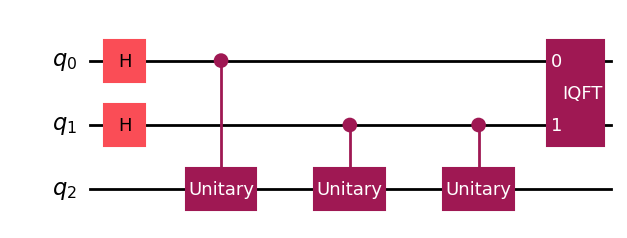

In [4]:
#Quantum Phase Estimation
qpe = QuantumCircuit(n+initialn)
iqpe = QuantumCircuit(n+initialn)

for i in range(initialn+n-1):
    qpe.h(i)
for k in range(initialn+n-1):
    for z in range(2**k):
        controlled_U = U_gate.control(1)
        qpe.append(controlled_U, [k, n])
        
qpe.append(IQFT, range(q))
QPE = qpe.to_gate(label="QPE")
iqpe = iqpe.compose(qpe.inverse())
IQPE = iqpe.to_gate(label="IQPE")
qpe.draw("mpl")

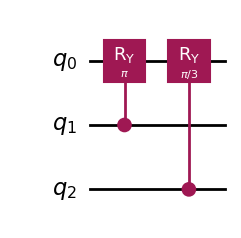

In [5]:
#Controlled Rotation
C = 1
crot = QuantumCircuit(n+1)
for i in range(n):  
    crot.cry(2 * math.asin(C / (i+1)), i+1, 0) #se usa cry en vez de cp porque no son la misma puerta, cry aplica amplitud tmb 
CROT = crot.to_gate(label="CROT")
crot.draw("mpl")

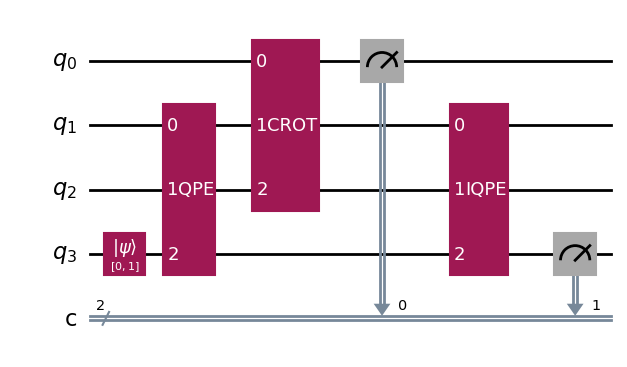

In [6]:
# Harrow–Hassidim–Lloyd Algorithm
HHL = QuantumCircuit(n+initialn+1,2)
HHL = HHL.compose(initialstate, range(n+1,n+1+initialn,1))
HHL = HHL.compose(QPE, range(1,initialn+1+n,1))
HHL = HHL.compose(CROT, range(n+1))
HHL.measure(0,0)
HHL = HHL.compose(IQPE, range(1,initialn+1+n,1))
HHL.measure(n+initialn,1)
HHL.draw("mpl")

Ratio de las soluciones:8.80859375


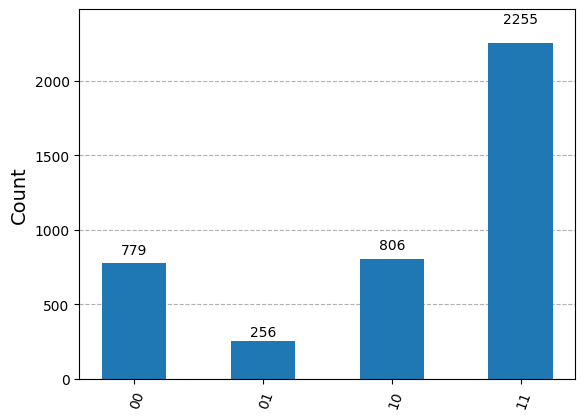

In [10]:
#SIMULACION IDEAL. NO NOISE

backend = GenericBackendV2(n+initialn+1)
transpiled_circuit = transpile(HHL, backend) 
job = backend.run(transpiled_circuit, shots = 4096, noise_model=None)
counts = job.result().get_counts()
print("Ratio de las soluciones:"+str(int(counts["11"])/int(counts["01"])))
plot_histogram(counts) #orden registros clasicos derecha el 0

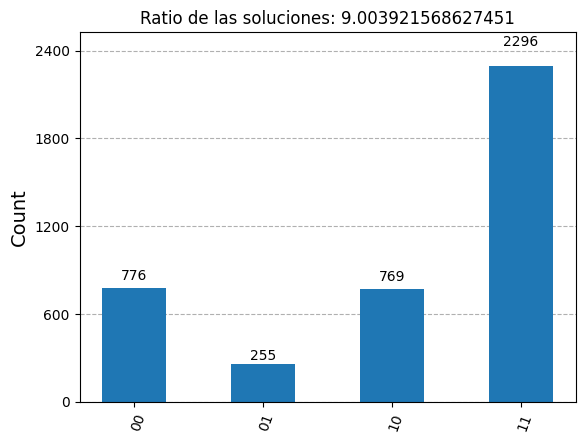

In [11]:
#SIMULACION REAL. WITH MODELED NOISE

noise_model = NoiseModel()

#1-qubit gate noise
error = depolarizing_error(0, 1)  #1-qubit gate error. 1% chance of being replaced by a completely random qubit (uniform over the Bloch sphere).
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x'])

#2-qubit gate noise
cx_error = depolarizing_error(0, 2) #Control X error. 
noise_model.add_all_qubit_quantum_error(cx_error, ['cx'])

noisy_backend = AerSimulator(noise_model=noise_model)
transpiled_circuit = transpile(HHL, noisy_backend)
job = noisy_backend.run(transpiled_circuit, shots=4096)
counts = job.result().get_counts()
plot_histogram(counts, title="Ratio de las soluciones: " + str(int(counts.get("11", 0)) / int(counts.get("01", 1))))

#transpiled_circuit.depth()

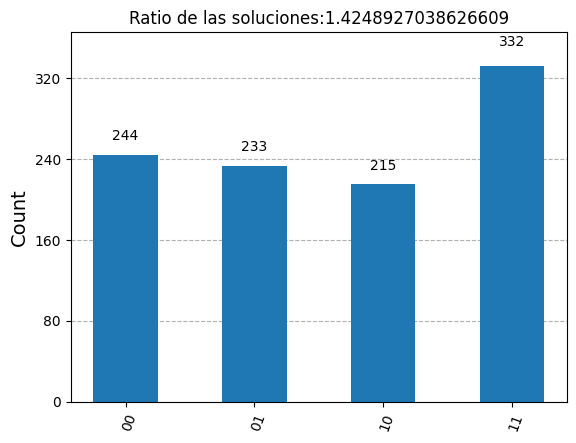

In [36]:
#SIMULACION REAL. NOISE SIMULATED. FAKE PROVIDER

backend = FakeKyiv()
initial_layout = [15,22,21,23] #Keys are virtual qubits, and values are physical qubits.

transpiled_circuit = transpile(HHL, backend, initial_layout = initial_layout) 
job = backend.run(transpiled_circuit, shots = 1024, optimization_level=3)
counts = job.result().get_counts()
plot_histogram(counts, title = "Ratio de las soluciones:"+str(int(counts["11"])/int(counts["01"]))) #orden registros clasicos derecha el 0



In [37]:
#SIMULACION REAL.

token = "001157e610e373c81cd9f59d74a91d346c12941a99675f9eef2336c57f483904b135842e974dd4856a62d6faf731fe59afbef1b70d929fd880cc72155af07d56"

QiskitRuntimeService.save_account(channel = 'ibm_quantum', instance = 'ibm-q/open/main', token = token, overwrite = True)
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
print(backend)
 
# Convert to an ISA circuit. OPTIMIZATION!
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout = initial_layout)
isaHHL = pm.run(HHL)
 
#isaHHL.draw("mpl", idle_wires=False)

sampler=SamplerV2(mode=backend)
job = sampler.run([isaHHL],shots=1024)
print(job.job_id())

<IBMBackend('ibm_brisbane')>
d0hr3cnvpqf00080nrgg


In [44]:
job.status()

<RuntimeJobV2('d0hr3cnvpqf00080nrgg', 'sampler')>

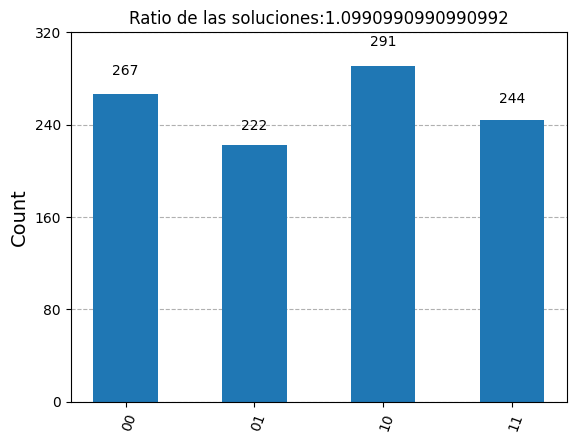

In [47]:
pub0    = result[0]           
countsreal = pub0.data.c.get_counts() 

plot_histogram(countsreal, title = "Ratio de las soluciones:"+str(int(countsreal["11"])/int(countsreal["01"]))) #orden registros clasicos derecha el 

In [48]:
#SIMULACION IDEAL. NO NOISE
backend = GenericBackendV2(n+initialn+1)
transpiled_circuit = transpile(HHL, backend)
Ratio = []
l = 1000
xcoor = np.linspace(0, 1, l)
for i in range(1,l+1):
    job = backend.run(transpiled_circuit, shots = 1024, noise_model=None)
    point = job.result().get_counts()
    Ratio.append(int(point["11"])/int(point["01"]))

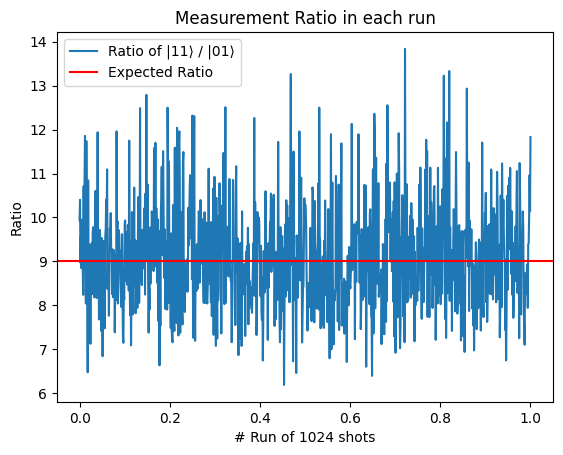

In [49]:
plt.rcParams["figure.dpi"] = 100

fig, ax1 = plt.subplots()
ax1.plot(xcoor, Ratio, label = "Ratio of |11⟩ / |01⟩")
ax1.set_xlabel("# Run of 1024 shots")
ax1.set_ylabel("Ratio")
ax1.set_title("Measurement Ratio in each run")
plt.axhline(9, color = "red", label = "Expected Ratio")
plt.legend()
plt.show()

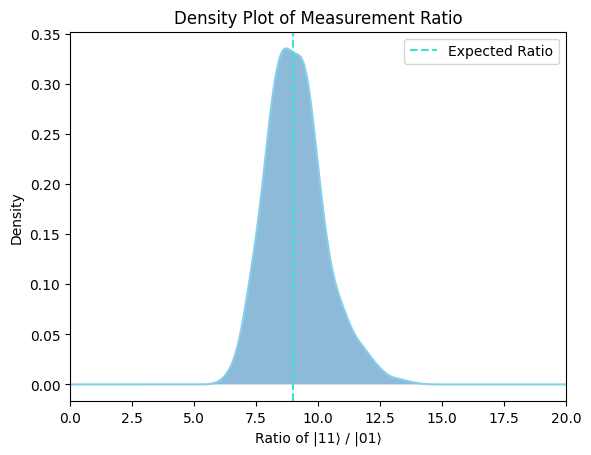

In [50]:
clean_ratio = np.array(Ratio)

density = gaussian_kde(clean_ratio, bw_method="silverman")
xs = np.linspace(0, 20, 500)
ys = density(xs)

fig, ax2 = plt.subplots()
ax2.set_xlim(0, 20)  # puedes ajustar este rango según lo que quieras ver
ax2.plot(xs, ys, color="skyblue")
ax2.fill_between(xs, ys, alpha=0.5)
ax2.axvline(9, color="turquoise", linestyle="--", label="Expected Ratio")
ax2.set_xlabel("Ratio of |11⟩ / |01⟩")
ax2.set_ylabel("Density")
ax2.set_title("Density Plot of Measurement Ratio")
ax2.legend()
plt.show()


In [51]:
import time

start = time.perf_counter()

######################################################################################################
backend = FakeKyiv()
initial_layout = [34,43,42,44] #Keys are virtual qubits, and values are physical qubits.

RatioFake = []
lFake = 1000
xcoorFake = np.linspace(0, 1, lFake)
for i in range(1,lFake+1):
    job = backend.run(transpiled_circuit, shots = 1024, optimization_level = 3)
    pointFake = job.result().get_counts()
    RatioFake.append(int(pointFake["11"])/int(pointFake["01"]))
########################################################################################################


time.sleep(2)

end = time.perf_counter()
print(f"Elapsed time: {end - start:.2f} seconds")

Elapsed time: 986.98 seconds


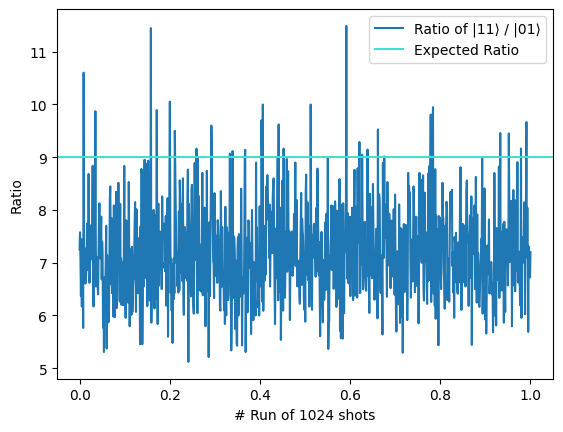

In [52]:
plt.rcParams["figure.dpi"] = 100

fig, ax3 = plt.subplots()
ax3.plot(xcoorFake, RatioFake, label = "Ratio of |11⟩ / |01⟩")
ax3.set_xlabel("# Run of 1024 shots")
ax3.set_ylabel("Ratio")
ax3.set_title("")
plt.axhline(9, color = "turquoise", label = "Expected Ratio")
plt.legend()
plt.show()

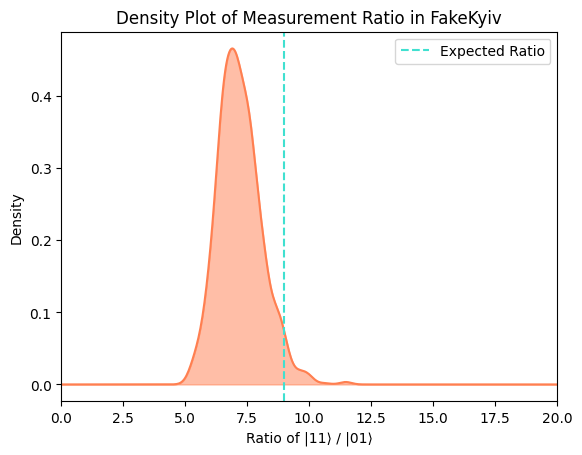

In [53]:
clean_ratioFake = np.array(RatioFake)

densityFake = gaussian_kde(clean_ratioFake, bw_method="silverman")
xsFake = np.linspace(0, 20, 500)
ysFake = densityFake(xsFake)

fig, ax4 = plt.subplots()
ax4.set_xlim(0, 20) # puedes ajustar este rango según lo que quieras ver
ax4.plot(xsFake, ysFake, color="coral")
ax4.fill_between(xsFake, ysFake, alpha=0.5, color="coral")
ax4.axvline(9, color="turquoise", linestyle="--", label="Expected Ratio")
ax4.set_xlabel("Ratio of |11⟩ / |01⟩")
ax4.set_ylabel("Density")
ax4.set_title("Density Plot of Measurement Ratio in FakeKyiv")
ax4.legend()
plt.show()


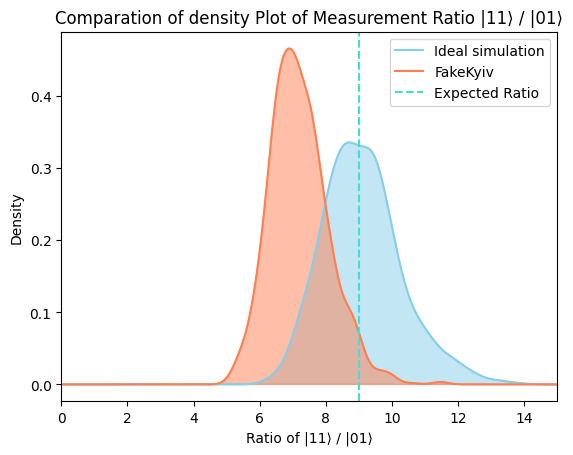

In [54]:
#COMPARATION FAKEKYIV AND IDEAL MEASUREMENT

fig, ax5 = plt.subplots()
ax5.set_xlim(0, 15)
ax5.plot(xs, ys, color="skyblue", label = "Ideal simulation")
ax5.plot(xsFake, ysFake, color="coral", label = "FakeKyiv")
ax5.fill_between(xs, ys, alpha=0.5, color="skyblue")
ax5.fill_between(xsFake, ysFake, alpha=0.5, color="coral")
ax5.axvline(9, color="turquoise", linestyle="--", label="Expected Ratio")
ax5.set_xlabel("Ratio of |11⟩ / |01⟩")
ax5.set_ylabel("Density")
ax5.set_title("Comparation of density Plot of Measurement Ratio |11⟩ / |01⟩")
ax5.legend()
plt.show()

In [70]:
#SIMULACION REAL.

token = "001157e610e373c81cd9f59d74a91d346c12941a99675f9eef2336c57f483904b135842e974dd4856a62d6faf731fe59afbef1b70d929fd880cc72155af07d56"

QiskitRuntimeService.save_account(channel = 'ibm_quantum', instance = 'ibm-q/open/main', token = token, overwrite = True)
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
print(backend)
initial_layout = [34,43,42,44]

# Convert to an ISA circuit. OPTIMIZATION!
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout = initial_layout)
isaHHL = pm.run(HHL)
pub0    = result[0]           
countsreal = pub0.data.c.get_counts() 
backend = service.least_busy(simulator=False, operational=True)
sampler=SamplerV2(mode = backend)
lReal = 20
xcoorReal = np.linspace(0, 1, lReal)
StoreReal  = []
pointsReal = {}
for i in range(1,lReal+1):
    job = sampler.run([isaHHL],shots=1024)
    pub0    = result[0]           
    pointsreal = pub0.data.c.get_counts() 
    StoreReal.append(pointsreal)
    time.sleep(60)
print(job.job_id())

<IBMBackend('ibm_sherbrooke')>
d0hsh1cehmr0008gkrw0


In [72]:
RatioReal = []
"""for i in StoreReal:   
    RatioReal.append(int(i["11"])/int(i["01"]))


clean_ratioReal = np.array(RatioReal)

densityReal = gaussian_kde(clean_ratioReal, bw_method="silverman")
xsReal = np.linspace(0, 15, 500)
ysReal = densityReal(xsReal)

fig, ax5 = plt.subplots()
ax5.set_xlim(0, 10)  # puedes ajustar este rango según lo que quieras ver
ax5.plot(xsReal, ysReal, color="plum")
ax5.fill_between(xsReal, ysReal, alpha=0.5, color="plum")
ax5.axvline(9, color="turquoise", linestyle="--", label="Expected Ratio")
ax5.set_xlabel("Ratio of |11⟩ / |01⟩")
ax5.set_ylabel("Density")
ax5.set_title("Density Plot of Measurement Ratio in ibm_kyiv")
ax5.legend()
plt.show()"""
StoreReal

[{'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244},
 {'00': 267, '10': 291, '01': 222, '11': 244}]

In [1]:
#COMPARATION BETWEEN IDEAL MEASUREMENT, FAKEKYIV AND IBM_KYIV


fig, ax5 = plt.subplots()
ax5.set_xlim(0, 15)
ax5.set_ylim(0,3.2)
ax5.plot(xs, ys, color="skyblue", label = "Ideal simulation")
ax5.plot(xsFake, ysFake, color="coral", label = "FakeKyiv")
ax5.plot(xsReal, ysReal, color="plum", label = "ibm_kyiv")
ax5.fill_between(xs, ys, alpha=0.5, color="skyblue")
ax5.fill_between(xsFake, ysFake, alpha=0.5, color="coral")
ax5.fill_between(xsReal, ysReal, alpha=0.5, color="plum")
ax5.axvline(9, color="turquoise", linestyle="--", label="Expected Ratio")
ax5.set_xlabel("Ratio of |11⟩ / |01⟩")
ax5.set_ylabel("Density")
ax5.set_title("Comparation of density Plot of Measurement Ratio |11⟩ / |01⟩")
ax5.legend()
plt.show()

NameError: name 'plt' is not defined